In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import statsmodels.api as sm
from scipy.special import gamma, loggamma, factorial
import scipy.stats
from scipy.interpolate import interp1d
from matplotlib.ticker import AutoMinorLocator 
from matplotlib import rc, font_manager
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors
from mycolorpy import colorlist as mcp
from matplotlib import legend_handler
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import collections
import matplotlib
import shapely.geometry
from shapely.geometry import Point
import shapely.ops 
from geopy.geocoders import Nominatim
import geopandas as gpd
import mapclassify
import jenkspy
import contextily as cx
import os
import rioxarray as rx
import pyreadr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from pysal.lib import weights
from libpysal.io import open as psopen
# import plots
import seaborn as sns
from datetime import datetime, timedelta
import jenkspy
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
warnings.filterwarnings("ignore")


In [2]:
wd = '/Users/carmen/Library/CloudStorage/OneDrive-TheUniversityofLiverpool/research/RECAST/latin-mobility-covid-local-files'

country = 'Argentina'

if country=='Argentina':
    country_short = 'ARG'
    country_code = 'AR'
elif country == 'Chile':
    country_short = 'CHL'
    country_code = 'CL'
elif country == 'Colombia':
    country_short = 'COL'
    country_code = 'CO'

In [3]:
category = 'density'

In [23]:
df_m3o = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_param_m3o.csv')
df_m4o = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_param_m4o.csv')
df_m5o = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_param_m5o.csv')


df_m3o_re = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_param_m3o_re.csv')
df_m4o_re = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_param_m4o_re.csv')
df_m5o_re = pd.read_csv(wd + '/data/outputs/' + country_short + '/mov-analysis/by-' + category + '/data_trend_param_m5o_re.csv')



In [40]:
df_m3o

,x
0,-25.992827
1,0.298174
2,1.882080
3,1.301482


In [36]:
df_m5o_re

,estimate,conf.low,conf.high,facet,term,title,reihe,group,p.label,xpos,xmin,xmax
0,4.847064,2.069692,7.624435,Of (Intercept),0,Random effects,1,pos,NaN,1,0.825,1.175
1,-0.471543,-3.253967,2.310882,Of (Intercept),1,Random effects,2,neg,NaN,2,1.825,2.175
2,1.639412,-1.136750,4.415573,Of (Intercept),2,Random effects,3,pos,NaN,3,2.825,3.175
3,1.944710,-0.831583,4.721004,Of (Intercept),3,Random effects,4,pos,NaN,4,3.825,4.175
4,-7.959210,-10.748323,-5.170097,Of (Intercept),4,Random effects,5,neg,NaN,5,4.825,5.175
5,-0.006409,-0.233470,0.220652,time,0,Random effects,1,neg,NaN,1,0.825,1.175
6,-0.035045,-0.265513,0.195423,time,1,Random effects,2,neg,NaN,2,1.825,2.175
7,0.001201,-0.225067,0.227469,time,2,Random effects,3,pos,NaN,3,2.825,3.175
8,0.001747,-0.224615,0.228110,time,3,Random effects,4,pos,NaN,4,3.825,4.175
9,0.038505,-0.194078,0.271089,time,4,Random effects,5,pos,NaN,5,4.825,5.175


In [61]:
df_m5o_re

,estimate,conf.low,conf.high,facet,term,title,reihe,group,p.label,xpos,xmin,xmax
0,4.847064,2.069692,7.624435,Of (Intercept),0,Random effects,1,pos,NaN,1,0.825,1.175
1,-0.471543,-3.253967,2.310882,Of (Intercept),1,Random effects,2,neg,NaN,2,1.825,2.175
2,1.639412,-1.136750,4.415573,Of (Intercept),2,Random effects,3,pos,NaN,3,2.825,3.175
3,1.944710,-0.831583,4.721004,Of (Intercept),3,Random effects,4,pos,NaN,4,3.825,4.175
4,-7.959210,-10.748323,-5.170097,Of (Intercept),4,Random effects,5,neg,NaN,5,4.825,5.175
5,-0.006409,-0.233470,0.220652,time,0,Random effects,1,neg,NaN,1,0.825,1.175
6,-0.035045,-0.265513,0.195423,time,1,Random effects,2,neg,NaN,2,1.825,2.175
7,0.001201,-0.225067,0.227469,time,2,Random effects,3,pos,NaN,3,2.825,3.175
8,0.001747,-0.224615,0.228110,time,3,Random effects,4,pos,NaN,4,3.825,4.175
9,0.038505,-0.194078,0.271089,time,4,Random effects,5,pos,NaN,5,4.825,5.175


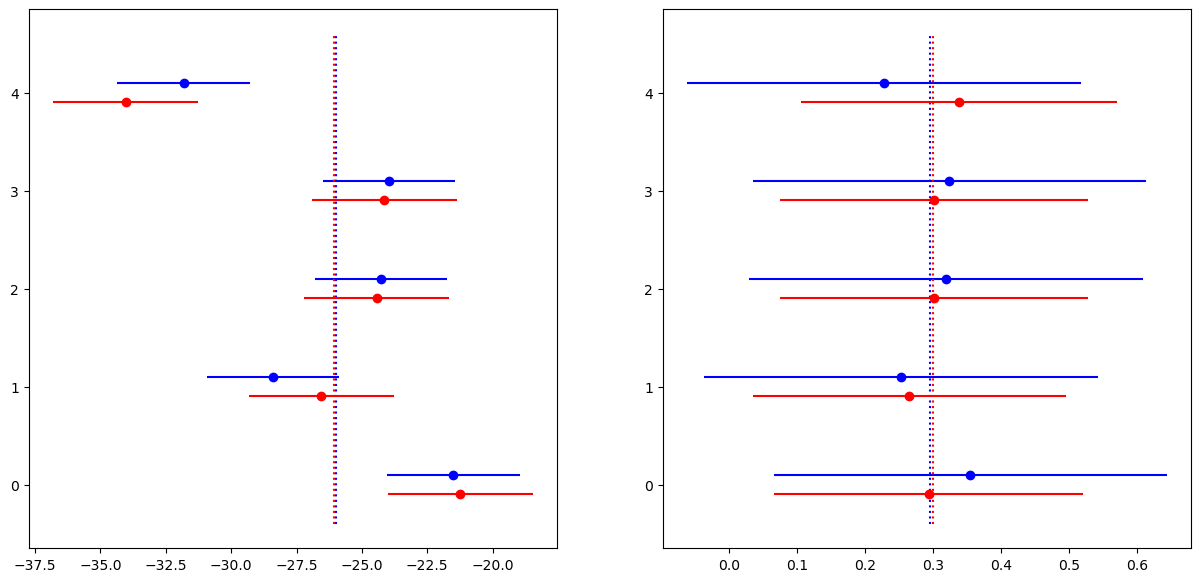

In [64]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,7))

left_error = df_m3o_re['estimate'] - df_m3o_re['conf.low'] 
right_error = df_m3o_re['conf.high'] - df_m3o_re['estimate'] 
ax1.errorbar(df_m3o_re['estimate'] + df_m3o.loc[0, 'x'], list(df_m3o_re.index+0.1), xerr=[left_error, right_error], fmt='o', color='blue')
ax1.plot([df_m3o.loc[0, 'x'], df_m3o.loc[0, 'x']], [min(list(df_m3o_re.index+0.1))-.5, max(list(df_m3o_re.index+0.1))+.5], linestyle=':', color='blue')

df_m5o_re_intercept = df_m5o_re[df_m5o_re['facet'].str.contains('Intercept')].reset_index(drop=True)
left_error = df_m5o_re_intercept['estimate'] - df_m5o_re_intercept['conf.low'] 
right_error = df_m5o_re_intercept['conf.high'] - df_m5o_re_intercept['estimate'] 
ax1.errorbar(df_m5o_re_intercept['estimate'] + df_m5o.loc[0, 'x'], list(df_m5o_re_intercept.index-0.1), xerr=[left_error, right_error], fmt='o', color='red')
ax1.plot([df_m5o.loc[0, 'x'], df_m5o.loc[0, 'x']], [min(list(df_m5o_re_intercept.index+0.1))-.5, max(list(df_m5o_re_intercept.index+0.1))+.5], linestyle=':', color='red')



left_error = df_m4o_re['estimate'] - df_m4o_re['conf.low'] 
right_error = df_m4o_re['conf.high'] - df_m4o_re['estimate'] 
ax2.errorbar(df_m4o_re['estimate'] + df_m4o.loc[1, 'x'], list(df_m4o_re.index+0.1), xerr=[left_error, right_error], fmt='o', color='blue')
ax2.plot([df_m4o.loc[1, 'x'], df_m4o.loc[1, 'x']], [min(list(df_m4o_re.index+0.1))-.5, max(list(df_m4o_re.index+0.1))+.5], linestyle=':', color='blue')

df_m5o_re_slope = df_m5o_re[df_m5o_re['facet'].str.contains('time')].reset_index(drop=True)
left_error = df_m5o_re_slope['estimate'] - df_m5o_re_slope['conf.low'] 
right_error = df_m5o_re_slope['conf.high'] - df_m5o_re_slope['estimate'] 
ax2.errorbar(df_m5o_re_slope['estimate'] + df_m5o.loc[1, 'x'], list(df_m5o_re_slope.index-0.1), xerr=[left_error, right_error], fmt='o', color='red')
ax2.plot([df_m5o.loc[1, 'x'], df_m5o.loc[1, 'x']], [min(list(df_m5o_re_slope.index+0.1))-.5, max(list(df_m5o_re_slope.index+0.1))+.5], linestyle=':', color='red')



In [19]:
list(df_m3o_re.index)

[0, 1, 2, 3, 4]